In [42]:
# Step 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve, auc)

import joblib

In [43]:
# Step 2: Upload dataset
from google.colab import files
uploaded = files.upload()

Saving heart.csv to heart (1).csv


In [47]:
# Load CSV
df = pd.read_csv("heart.csv")
print("Original Shape:", df.shape)

Original Shape: (920, 16)


In [48]:
# Step 3: Data cleaning
# Drop unused columns
df = df.drop(columns=["id", "dataset"])

# Convert target 'num' into binary (0 = no disease, 1 = disease)
df["num"] = (df["num"] > 0).astype(int)

print("Processed Shape:", df.shape)
print("Target distribution:\n", df["num"].value_counts())

Processed Shape: (920, 14)
Target distribution:
 num
1    509
0    411
Name: count, dtype: int64


In [50]:
# Step 4: Define features and target
X = df.drop(columns=["num"])
y = df["num"]

In [51]:
# Step 5: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train Shape:", X_train.shape, "Test Shape:", X_test.shape)

Train Shape: (736, 13) Test Shape: (184, 13)


In [52]:
# Step 6: Preprocessing
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])


=== Logistic Regression Report ===
              precision    recall  f1-score   support

           0       0.84      0.79      0.82        82
           1       0.84      0.88      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184

Accuracy: 0.842391304347826
ROC-AUC: 0.9035150645624103


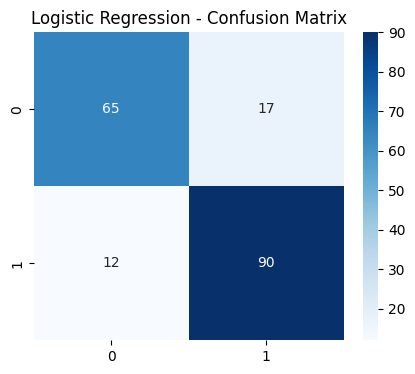

In [53]:
# Step 7: Logistic Regression
clf_lr = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

print("\n=== Logistic Regression Report ===")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, clf_lr.predict_proba(X_test)[:,1]))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap="Blues")
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

In [54]:
# Step 8: Random Forest
clf_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

print("\n=== Random Forest Report ===")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, clf_rf.predict_proba(X_test)[:,1]))


=== Random Forest Report ===
              precision    recall  f1-score   support

           0       0.85      0.80      0.82        82
           1       0.85      0.88      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.85       184
weighted avg       0.85      0.85      0.85       184

Accuracy: 0.8478260869565217
ROC-AUC: 0.9199545671927307


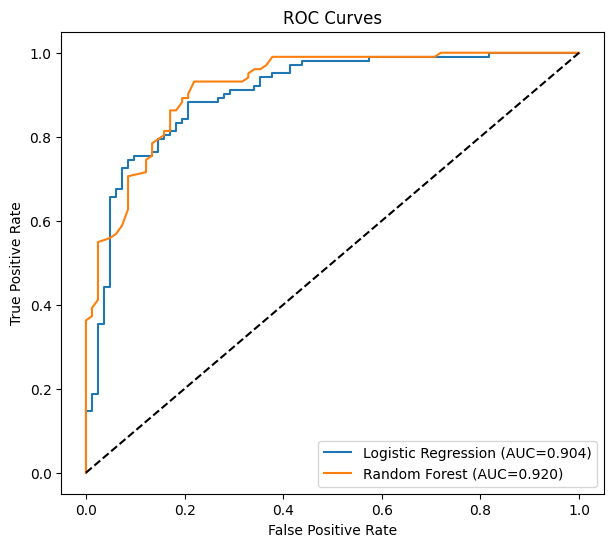

In [55]:
# Step 9: ROC Curve
plt.figure(figsize=(7,6))
for model, name in [(clf_lr, "Logistic Regression"), (clf_rf, "Random Forest")]:
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


In [56]:
# Step 10: Hyperparameter Tuning (Random Forest)
param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [None, 5, 10]
}

rf_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

grid_search = GridSearchCV(rf_pipe, param_grid, cv=3, scoring="roc_auc", n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nBest RF Parameters:", grid_search.best_params_)
print("Best CV ROC-AUC:", grid_search.best_score_)

best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
print("\n=== Best RF Test Report ===")
print(classification_report(y_test, y_pred_best))
print("Test ROC-AUC:", roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]))


Best RF Parameters: {'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Best CV ROC-AUC: 0.8841439307629271

=== Best RF Test Report ===
              precision    recall  f1-score   support

           0       0.86      0.82      0.84        82
           1       0.86      0.89      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.85      0.86       184
weighted avg       0.86      0.86      0.86       184

Test ROC-AUC: 0.9281444285031086


In [57]:
# Step 11: Save the best model
joblib.dump(best_rf, "heart_disease_model.joblib")
print("\nModel saved as heart_disease_model.joblib")


Model saved as heart_disease_model.joblib


In [58]:
# Step 12: Example predictions
sample = X_test.iloc[:5]
preds = best_rf.predict(sample)
probs = best_rf.predict_proba(sample)[:,1]

print("\nSample Predictions (first 5 rows of X_test):")
print(pd.DataFrame({"Prediction": preds, "Probability": probs}, index=sample.index))


Sample Predictions (first 5 rows of X_test):
     Prediction  Probability
514           0     0.405828
825           1     0.892359
854           1     0.646203
804           1     0.890727
887           0     0.493448
